# Multisensor rail detection in automatic train operations - Exploratory data analysis

Attila Kovacs
25.9.2023

## Introduction

In this notebook, we will perform the exploratory data analysis for the multi-sensor dataset provided by Deutsch Bahn / Digitale Schiene Deutschland (https://digitale-schiene-deutschland.de/en/news/OSDaR23-multi-sensor-data-set-for-machine-learning).
The goal is to get a deep understanding of the characteristics of the datasets and how it can be best applied to solve the rail detection problem.



## Requiered packages

In [1]:
#from config import settings
import os
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import re
import cv2
from easyimages import EasyImage, EasyImageList, bbox
from easyimages.easyimages import CTX

from utils import print_image, parse_input, print_map, calculate_brightness

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline


## Load metadata

The total number of label IDs in the dataset is 236.467.
Extracting this number is important in order to check against the dataframe that is being used for analysis.

In [2]:
number_labels_uid = 0
for d in os.listdir("./orig_data/DB/"):
    file_name = glob(f"./orig_data/DB/{d}/*.json")[0]
    with open(file_name) as f:
        raw = f.read()
        number_labels_uid += len(re.findall("uid", raw))
number_labels_uid

236467

Next, we load the actual data that we want to use for the exploration.
There is one metadata file for each sub-dataset comprising the required information about the sensors, objects, and labels.

In [35]:
df = parse_input()

./orig_data/DB/10_station_suelldorf_10.1\10_station_suelldorf_10.1_labels.json
./orig_data/DB/11_main_station_11.1\11_main_station_11.1_labels.json
./orig_data/DB/12_vegetation_steady_12.1\12_vegetation_steady_12.1_labels.json
./orig_data/DB/13_station_ohlsdorf_13.1\13_station_ohlsdorf_13.1_labels.json
./orig_data/DB/14_signals_station_14.1\14_signals_station_14.1_labels.json
./orig_data/DB/14_signals_station_14.2\14_signals_station_14.2_labels.json
./orig_data/DB/14_signals_station_14.3\14_signals_station_14.3_labels.json
./orig_data/DB/15_construction_vehicle_15.1\15_construction_vehicle_15.1_labels.json
./orig_data/DB/16_under_bridge_16.1\16_under_bridge_16.1_labels.json
./orig_data/DB/17_signal_bridge_17.1\17_signal_bridge_17.1_labels.json
./orig_data/DB/18_vegetation_switch_18.1\18_vegetation_switch_18.1_labels.json
./orig_data/DB/19_vegetation_curve_19.1\19_vegetation_curve_19.1_labels.json
./orig_data/DB/1_calibration_1.1\1_calibration_1.1_labels.json
./orig_data/DB/1_calibratio

An example of the dataframe including the used columns is given below.

In [36]:
df.columns

Index(['longitude', 'latitude', 'tag', 'type', 'object_uid', 'name',
       'label_uid', 'sensor', 'height', 'width', 'path', 'dataset',
       'timestamp', 'label_type', 'closed', 'val', 'occlusion', 'railSide'],
      dtype='object')

* longitude: GPS coordinate
* latitude: GPS coordinate
* tag: sub-dataset
* type: object type or class
* object_uid: ID of object (same object can be detected in different images)
* name: combination of sensor, annotation type, and type
* label_uid: ID of label or annotation
* sensor: type of sensor
* height: height of image
* width: width of image
* path: path to image
* dataset: is equal to tag, but is kept as both names are used in the original data
* timestamp 
* label_type: there are different annotation types (e.g., polyline, bounding box, polygon)
* closed: whether or not polyline is closed
* val: value of polyline
* occlusion: visibility of object in image
* railSide: indicates whether annotation refers to left or right side of the track


In [37]:
df.head()

longitude   latitude                        tag    type  \
0   9.797191  53.581087  10_station_suelldorf_10.1  signal   
1   9.797191  53.581087  10_station_suelldorf_10.1  signal   
2   9.797191  53.581087  10_station_suelldorf_10.1  signal   
3   9.797191  53.581087  10_station_suelldorf_10.1  signal   
4   9.797191  53.581087  10_station_suelldorf_10.1  signal   

                             object_uid                                name  \
0  02ca6d43-1f4a-4812-a145-f409be84f405           ir_center__poly2d__signal   
1  02ca6d43-1f4a-4812-a145-f409be84f405          rgb_center__poly2d__signal   
2  02ca6d43-1f4a-4812-a145-f409be84f405  rgb_highres_center__poly2d__signal   
3  02ca6d43-1f4a-4812-a145-f409be84f405               lidar__cuboid__signal   
4  02ca6d43-1f4a-4812-a145-f409be84f405                  lidar__vec__signal   

                              label_uid              sensor  height  width  \
0  18969f90-f21d-4fbb-af9d-de98b6d4a966           ir_center     480    640   
1  5adc793e-a3ea-4a79-a994-ccfb505e0c40          rgb_center    1600   2464   
2  05d901a1-cde6-4a4b-9730-71b6033f4ac8  rgb_highres_center    2504   4112   
3  9f432542-0f6b-43f0-a98f-3a7916a02475               lidar    3008   4112   
4  2fb1acff-900a-4d13-b6f6-506dae68f5fe               lidar    3008   4112   

                                                path  \
0  10_station_suelldorf_10.1/ir_center/216_163170...   
1  10_station_suelldorf_10.1/rgb_center/216_16317...   
2  10_station_suelldorf_10.1/rgb_highres_center/2...   
3  10_station_suelldorf_10.1/lidar/216_1631703820...   
4  10_station_suelldorf_10.1/lidar/216_1631703820...   

                     dataset             timestamp label_type closed  val  \
0  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
1  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
2  10_station_suelldorf_10.1  1631703820.699805000     poly2d    NaN  NaN   
3  10_station_suelldorf_10.1  1631703820.699805000     cuboid    NaN  NaN   
4  10_station_suelldorf_10.1  1631703820.699805000        vec    NaN  NaN   

  occlusion railSide  
0       NaN      NaN  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN

## Analyize whole dataset

First, we look at the entire dataset.
The images have been generated between '2021-09-09 08:28:22' and  '2021-09-15 15:25:53'.
That is, we cannot expect to observe seasonal differences (e.g., snow)


In [38]:
# earliest record
datetime.utcfromtimestamp(float(df.timestamp.min())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-09 08:28:22'

In [39]:
# latest record
datetime.utcfromtimestamp(float(df.timestamp.max())).strftime("%Y-%m-%d %H:%M:%S")

'2021-09-15 15:25:53'

### Images

The number of images in the dataset is 13.952. This involves images from different cameras, infrared sensors, lidar, and radar.

In [40]:
# number of images
len(df.path.unique())

13952

The number of labeled images per sensor is given blow. Left and right oriented sensors as well as infrared sensors do not always contain an image.

sensor
ir_right               966
rgb_right             1024
rgb_highres_right     1034
ir_left               1146
rgb_highres_left      1308
rgb_left              1314
radar                 1421
lidar                 1434
ir_center             1435
rgb_center            1435
rgb_highres_center    1435
Name: path, dtype: int64

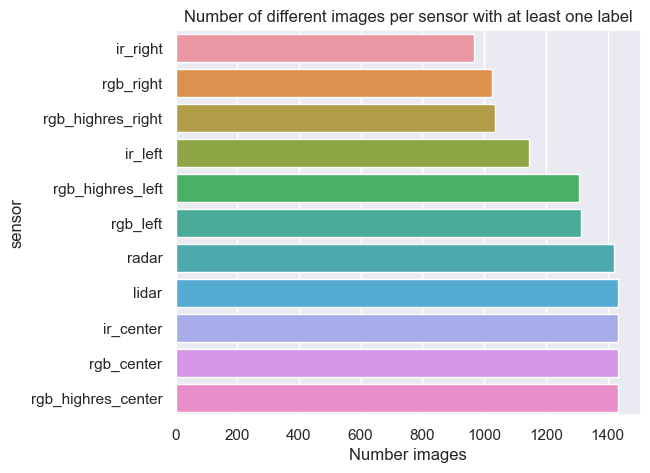

In [42]:
# labeled images per sensor
sns.set(rc={"figure.figsize": (6, 5)})
df_temp = df.groupby(["sensor"])["path"].nunique().sort_values()
ax = sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of different images per sensor with at least one label",
    xlabel="Number images",
)
df_temp

We also give the number of images that display a given object class. The classes observed in the most images are persons, tracks, and signals. Motorcycles, drag shoes and wagons are observed least often in the images.

type
person               9632
track                8855
signal               6916
signal_pole          5735
train                5350
catenary_pole        4351
road_vehicle         3724
buffer_stop          2843
switch               1952
bicycle              1398
crowd                1196
animal               1179
group_of_bicycles     625
flame                 410
transition            388
smoke                 188
signal_bridge         132
wagons                110
drag_shoe              59
motorcycle              9
Name: count, dtype: int64

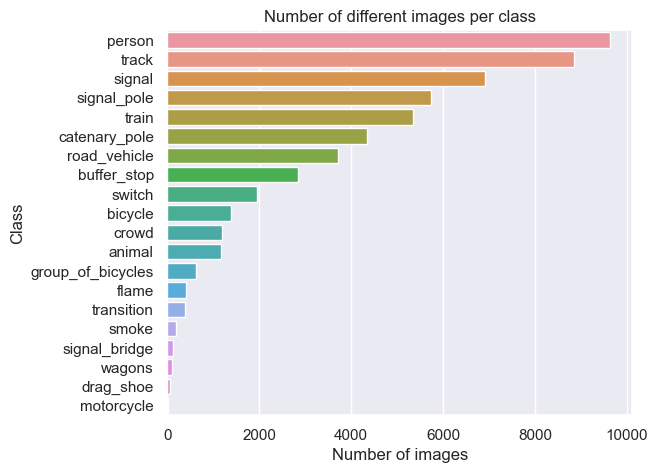

In [44]:
# images per label
df_temp = df[["type", "path"]].drop_duplicates()["type"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of different images per class",
    xlabel="Number of images",
    ylabel="Class",
)
df_temp

### Annotations

The number of annotations matches the number of unique IDs in the input file. In total we have 236.467 labels.

In [45]:
# number of labels
assert number_labels_uid == len(df)
len(df)

236467

The number of labels depends on the sensor and the orientation. For example, IR cameras pick up less objects than lidar, radar or rgb.
Sensors oriented to the left or right pick up less objects than sensors oriented to the center.

sensor
lidar                 56072
rgb_highres_center    41827
rgb_center            36505
radar                 24290
ir_center             18312
rgb_highres_left      12380
rgb_highres_right     12213
rgb_left              11471
rgb_right              9555
ir_left                7841
ir_right               6001
Name: count, dtype: int64

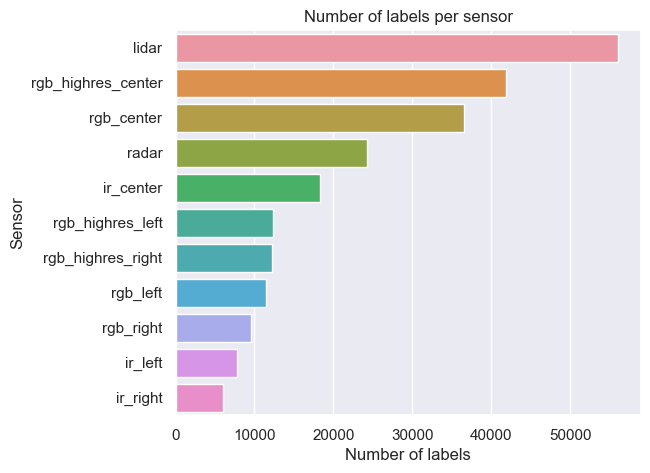

In [46]:
# lables per sensor
df_temp = df["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per sensor", xlabel="Number of labels", ylabel="Sensor"
)
df_temp

There is a clear imbalance in the labeled classes. However, we are not affected by the imbalance as need only the class "track".

type
person               83547
signal               33499
track                33049
catenary_pole        31044
signal_pole          14531
road_vehicle         11994
train                10113
buffer_stop           5284
animal                3811
switch                3351
bicycle               1896
crowd                 1458
transition            1093
group_of_bicycles      644
flame                  410
signal_bridge          332
smoke                  188
wagons                 130
drag_shoe               79
motorcycle              14
Name: count, dtype: int64

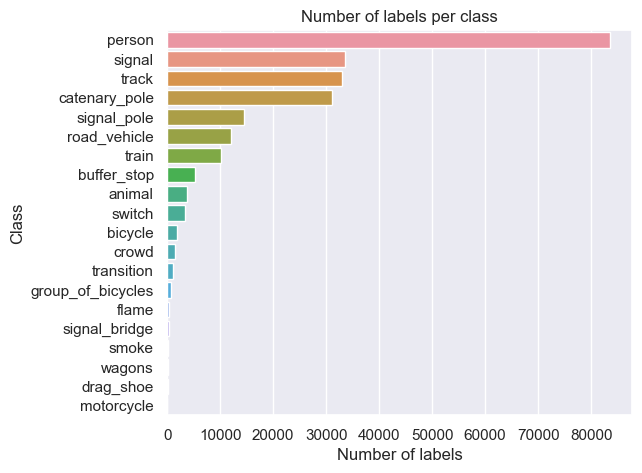

In [48]:
# annotations per class
df_temp = df["type"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per class", xlabel="Number of labels", ylabel="Class"
)
df_temp

## Analize only relevant data (i.e, class = track)

As we are interested in identifying tracks only, we filter the dataframe accordingly. We also focus only on RGB and IR cameras.

In [49]:
# filter only on relevant data
df = df[(df["type"] == "track") & (df["label_type"] == "poly2d")]
df["poly2d"] = df.val.apply(lambda x: np.array(np.reshape(x, (-1, 2)), dtype=np.int32))

There are 27.386 labels in 7.421 images left after the filtering.

In [50]:
# number of labels
len(df)

27386

In [51]:
# number of images
len(df.path.unique())

7421

The characteristics of the relevant sensors is given below. For each sensor, there is a trident alignment (i.e., diagonal left, central, and diagonal right)

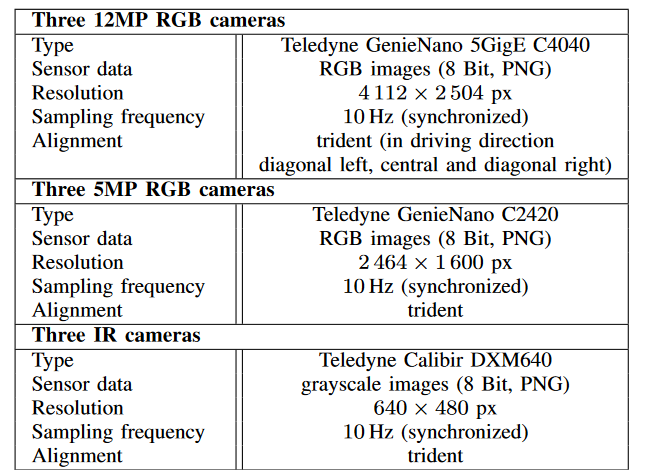

We can see that there are less images showing tracks when sensors are oriented to the left or to the right compared to sensors oriented to the front.

sensor
ir_center             1435
rgb_center            1435
rgb_highres_center    1435
rgb_highres_right      805
ir_right               574
rgb_right              565
ir_left                398
rgb_highres_left       397
rgb_left               377
Name: count, dtype: int64

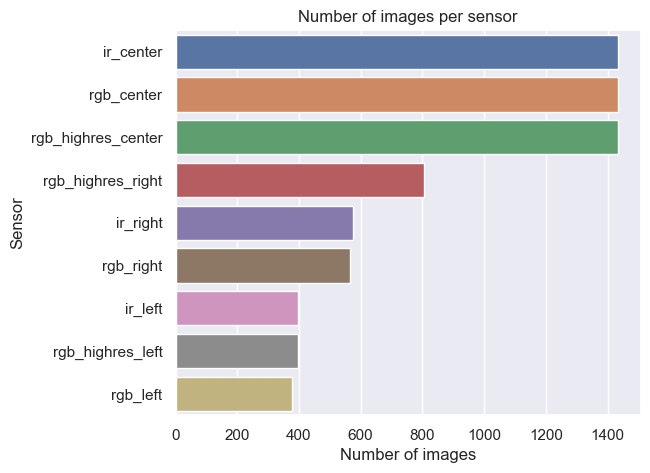

In [52]:
df_temp = df[["sensor", "path"]].drop_duplicates()["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of images per sensor", xlabel="Number of images", ylabel="Sensor"
)
df_temp

The number of labels per sensor is given below. 

sensor
rgb_highres_center    6894
rgb_center            6595
ir_center             4736
rgb_highres_right     2230
ir_right              1767
rgb_right             1592
ir_left               1248
rgb_highres_left      1176
rgb_left              1148
Name: count, dtype: int64

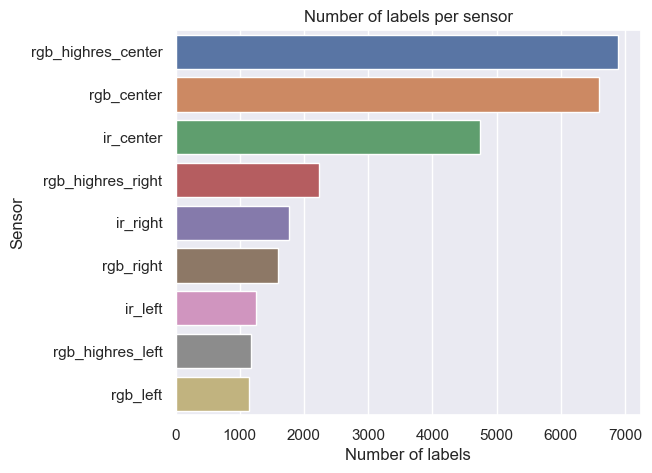

In [53]:
# lables per sensor
df_temp = df["sensor"].value_counts()
sns.barplot(y=df_temp.index, x=df_temp).set(
    title="Number of labels per sensor", xlabel="Number of labels", ylabel="Sensor"
)
df_temp

### Analyzing the aspect of the images

Aspect ratio of an image is defined as width / height. Having information about the aspect ratio is important when selecting or designing a deep learning model.

In [54]:
df_aspect = df[["path", "width", "height", "sensor"]].drop_duplicates()
df_aspect["aspect_ratio"] = df_aspect.apply(lambda x: x.width / x.height, axis=1)
df_aspect.head()

path  width  height  \
28   10_station_suelldorf_10.1/ir_center/216_163170...    640     480   
30   10_station_suelldorf_10.1/rgb_center/216_16317...   2464    1600   
32   10_station_suelldorf_10.1/rgb_highres_center/2...   4112    2504   
176  10_station_suelldorf_10.1/ir_center/217_163170...    640     480   
178  10_station_suelldorf_10.1/rgb_center/217_16317...   2464    1600   

                 sensor  aspect_ratio  
28            ir_center      1.333333  
30           rgb_center      1.540000  
32   rgb_highres_center      1.642173  
176           ir_center      1.333333  
178          rgb_center      1.540000

The images in the dataset come in three different aspect rations as indicated above.
Here we want to make sure that no other images have found their way into the dataset.

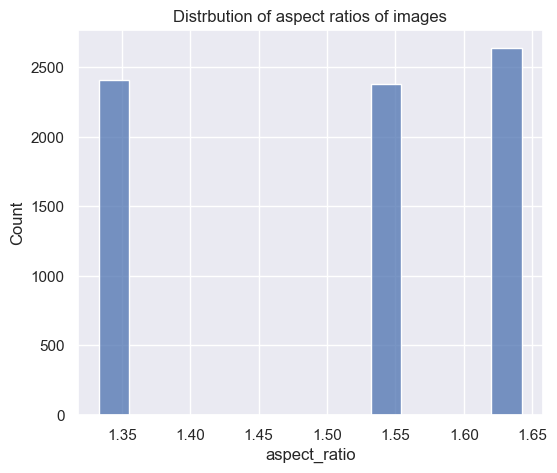

In [55]:
_ = sns.histplot(df_aspect.aspect_ratio).set(
    title="Distrbution of aspect ratios of images"
)

The sensors have different aspect ratios. The high resolution cameras provide the widest images, where infrared cameras are the narrowest.

[Text(0.5, 1.0, 'Aspect ratios of sensors')]

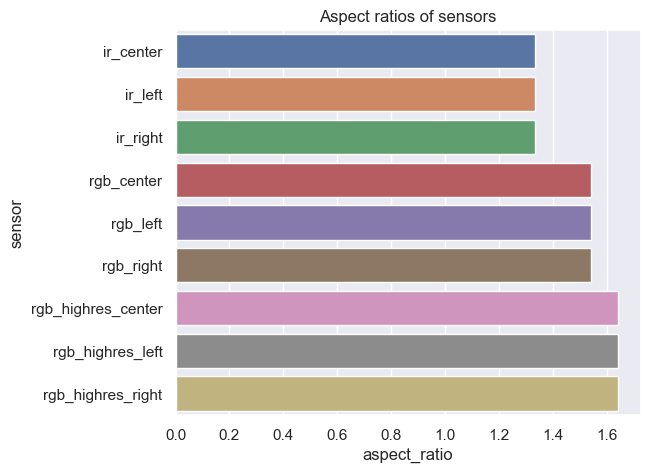

In [56]:
sns.barplot(df_aspect.sort_values("aspect_ratio"), x="aspect_ratio", y="sensor").set(
    title="Aspect ratios of sensors"
)

The respective width and height are given below. They all align with the specifications of the cameras.

In [58]:
df[["width", "height", "sensor"]].drop_duplicates().sort_values("width")

width  height              sensor
28       640     480           ir_center
2809     640     480            ir_right
11119    640     480             ir_left
30      2464    1600          rgb_center
2813    2464    1600           rgb_right
11123   2464    1600            rgb_left
32      4112    2504  rgb_highres_center
2817    4112    2504   rgb_highres_right
11127   4112    2504    rgb_highres_left

### Labels per image

In the histogram below, we visualize the number of labels (i.e., single tracks) in the images.
As expected, rail tracks come in pair (left side and right side). Nevertheless, there is also a low number of images showing only one part of the rail tracks.


[Text(0.5, 1.0, 'Histogram of labels per image'),
 Text(0.5, 0, 'Number of labels')]

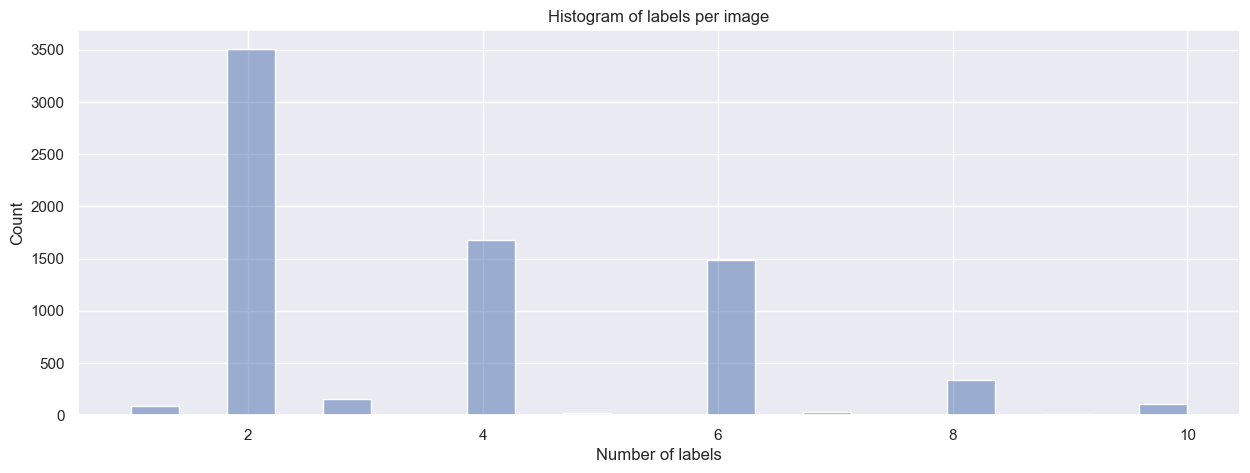

In [59]:
sns.set(rc={"figure.figsize": (15, 5)})
df_classes_count = df.groupby(["path"], as_index=False).agg(
    classes_count=("label_uid", lambda x: x.nunique())
)
sns.histplot(df_classes_count, legend=False).set(
    title="Histogram of labels per image", xlabel="Number of labels"
)

### Local distribution

The videos/images have all be generated in the area of Hamburg. By zooming in, we can see the movement of the vehicle during taking the video.

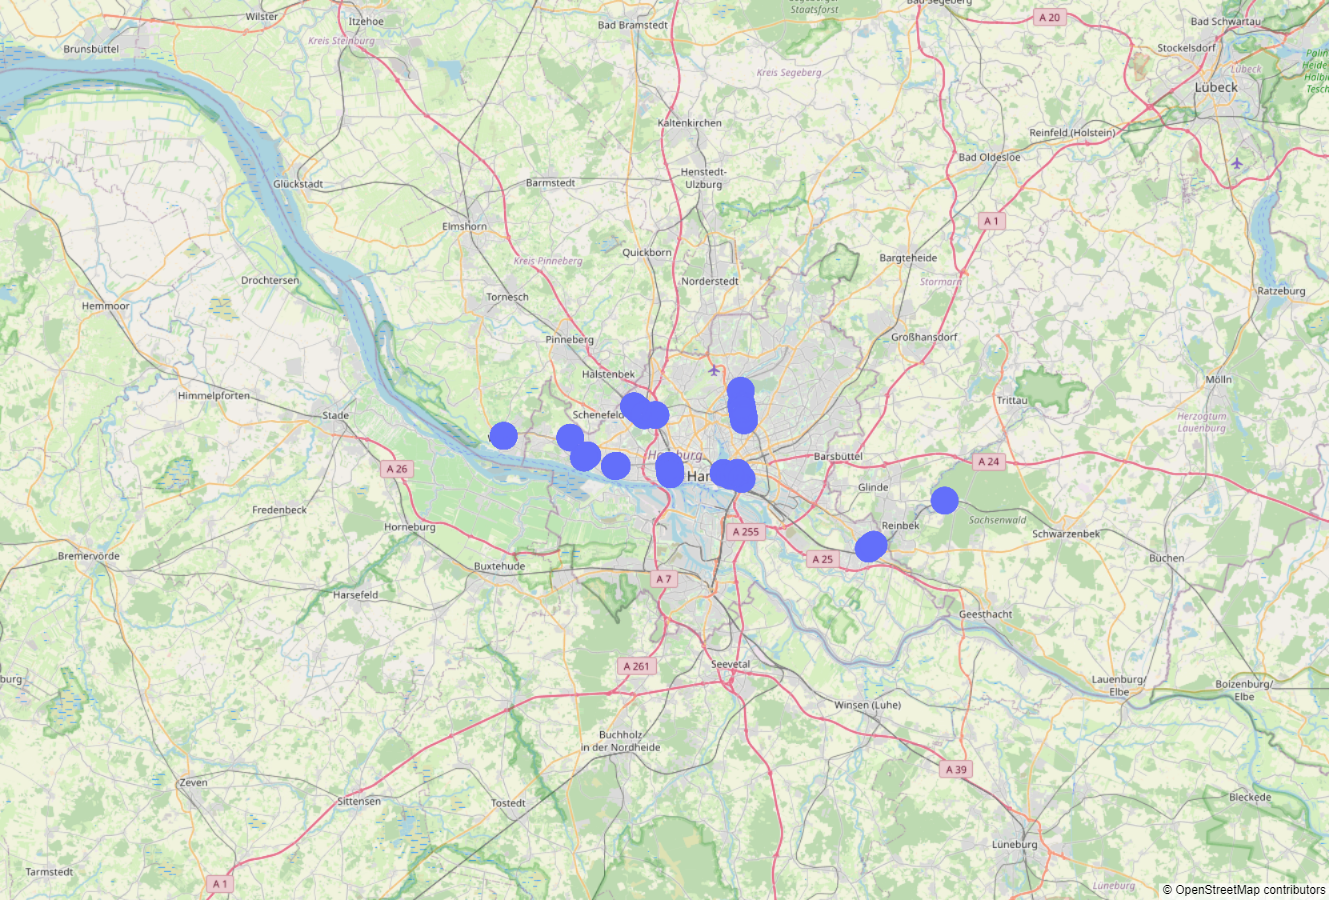

In [60]:
print_map(df)

### Temporal distribution

As all images/videos have been taken between 8AM and 17PM, we cannot expect to test the effect of different sensors in the night.

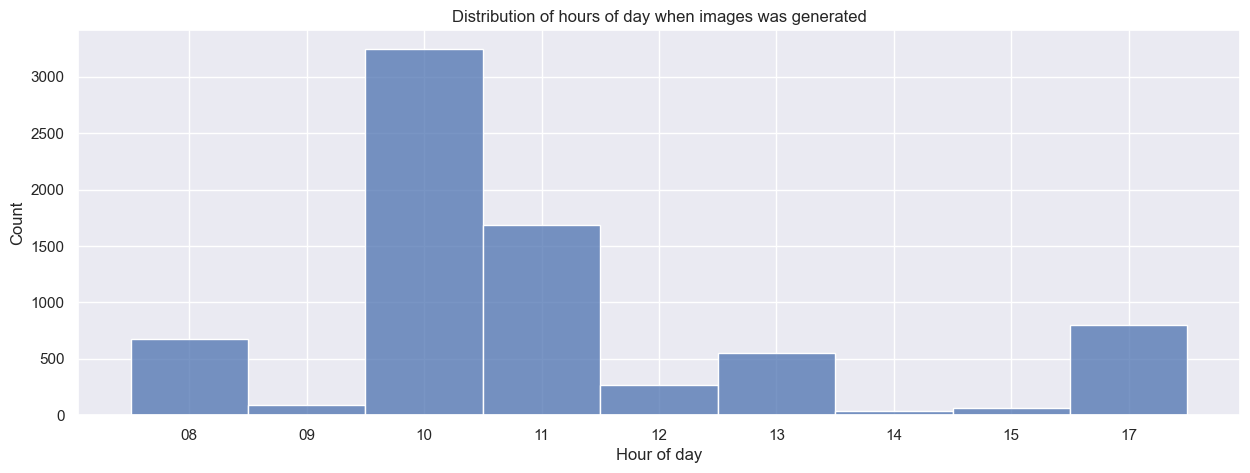

In [61]:
sns.set(rc={"figure.figsize": (15, 5)})
df_temp = (
    df[["path", "timestamp"]]
    .drop_duplicates()
    .apply(
        lambda x: datetime.utcfromtimestamp(float(x.timestamp)).strftime("%H"), axis=1
    )
    .sort_values()
)
_ = sns.histplot(df_temp).set(
    title="Distribution of hours of day when images was generated", xlabel="Hour of day"
)

### Some examples

Next, we visualize some images and plot the labels in red in order to get a feeling for the dataset.
There is a wide range of images, e.g. from different sensors, different locations, and different perspectives.

12_vegetation_steady_12.1/rgb_highres_right/009_1631177221.000000022.png


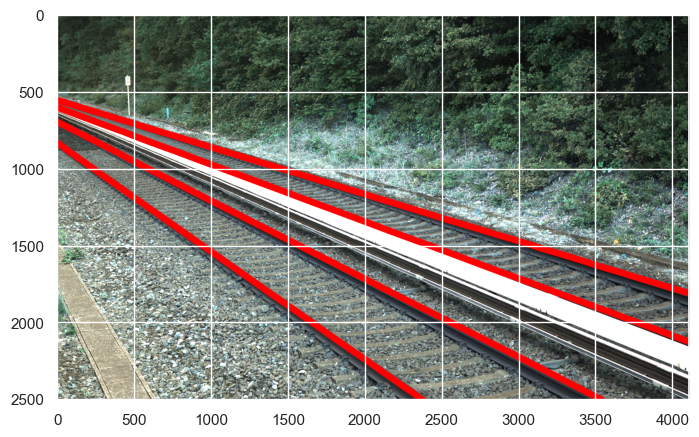

In [62]:
path = df[df.path.str.contains("high")].path.unique()[39]
print_image(df, path, True)

11_main_station_11.1/rgb_highres_center/277_1631531579.800000026.png


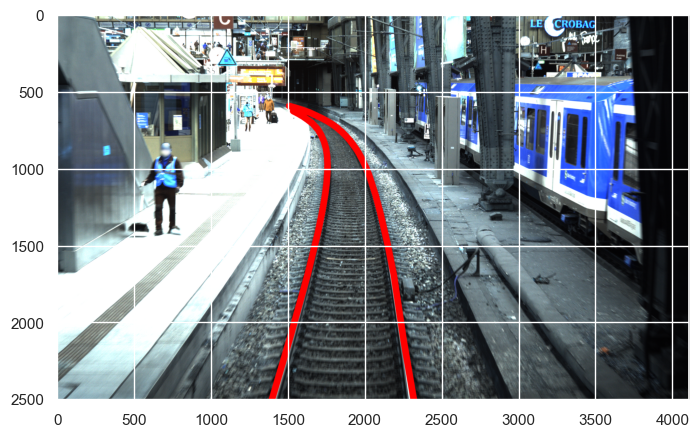

11_main_station_11.1/rgb_highres_center/277_1631531579.800000026.png


In [63]:
path = df.path.unique()[35]
print_image(df, path, True)
print(path)

10_station_suelldorf_10.1/rgb_center/219_1631703821.000000000.png


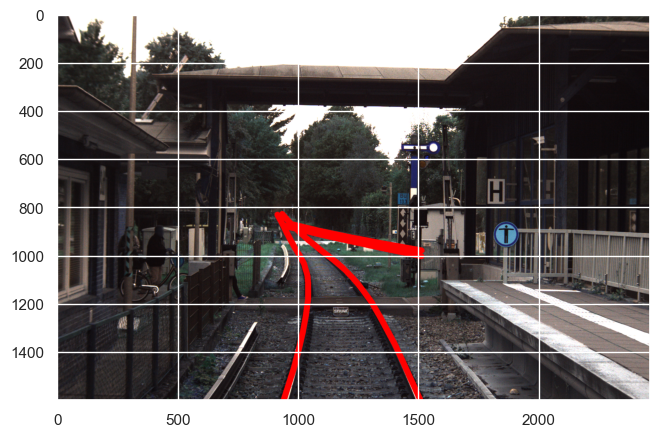

10_station_suelldorf_10.1/rgb_center/219_1631703821.000000000.png


In [64]:
path = df.path.unique()[10]
print_image(df, path, True)
print(path)

12_vegetation_steady_12.1/ir_center/002_1631177220.300465200.png


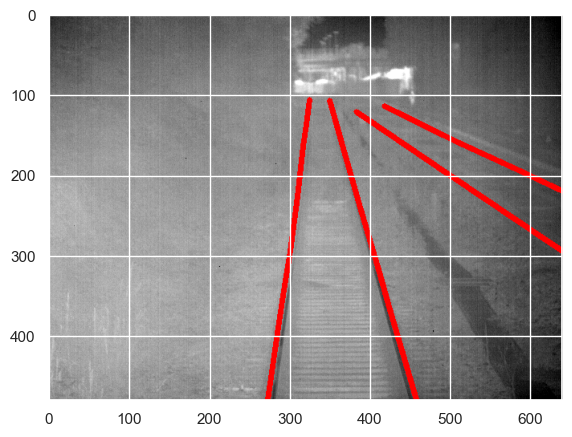

12_vegetation_steady_12.1/ir_center/002_1631177220.300465200.png


In [65]:
path = df[df["sensor"] == "ir_center"].path.unique()[22]
print_image(df, path, True)
print(path)

### Analyze the brightness of the images

As observed above, the images vary widely in their brightness. It is to be expected that the brightness plays an important role in achieving a high accuracy when predicting tracks. Therefore, we analyze the brightness of the images per sensor.

In [66]:
%%time
## calculating the birghtness for each image takes around 30min. Therefore, we load the data from the hard drive if available.
files = glob('./dataframe_dumps/brightness_dump_*')
print(files)
if len(files) > 0:
    df_temp = pd.read_csv(max(files, key=os.path.getmtime))
else:
    df_temp = df[["path", "sensor"]].drop_duplicates()
    df_temp["brightness"] = df_temp.apply(lambda x: calculate_brightness(f"./orig_data/DB/{x.path}"), axis=1)
    brightness_dump = f"./dataframe_dumps/brightness_dump_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
    df_temp.to_csv(brightness_dump, index=False)

['./dataframe_dumps\\brightness_dump_09-28-2023_09-48-37.csv']
CPU times: total: 0 ns
Wall time: 20.3 ms


Among the three sensors, RGB cameras produce the darkest images. High resolution images tend to be the brightest. Infrared cameras produce images with almost constant brightness.
Note however, that the brightness does not depend on the resolution of the camera. There are other aspects such as exposure time. Higher resolutions means that there more pixels per area which results crisper images.


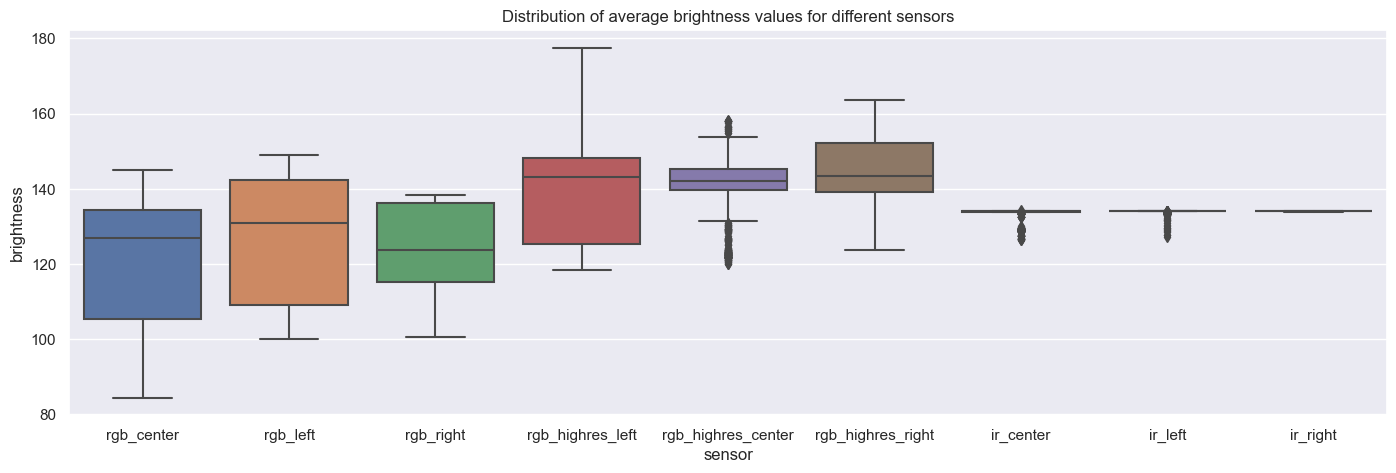

In [68]:
sns.set(rc={"figure.figsize": (17, 5)})
_ = sns.boxplot(
    df_temp[["sensor", "brightness"]].sort_values("brightness"),
    x="sensor",
    y="brightness",
).set(title="Distribution of average brightness values for different sensors")

### Occlusion

As we have seen above, there are certain labels that are hidden behind, e.g., trees or are not fully visible due to a train travelling on the track segment.
So, we analyze the occlusion of the labels.

The major part of the track labels is visible. 320 labels have an occlusion factor of 100%.  


occlusion
0-25 %     20069
75-99 %     3083
25-50 %     2502
50-75 %     1412
100 %        320
Name: count, dtype: int64

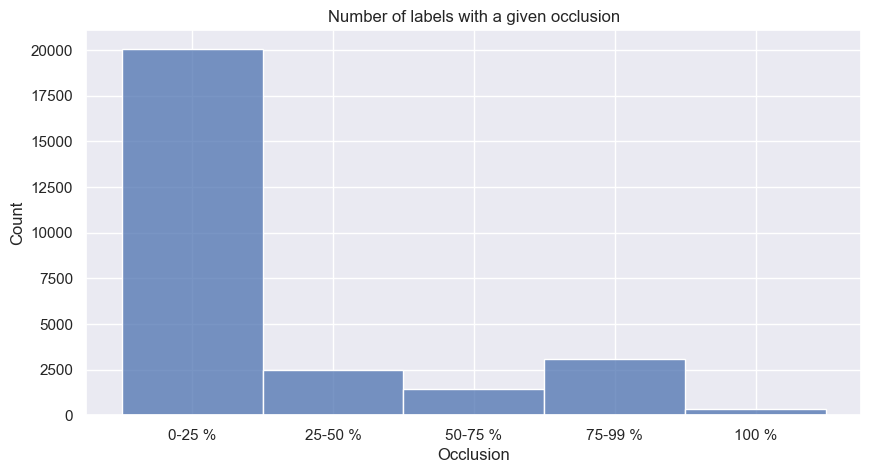

In [87]:
sns.set(rc={"figure.figsize": (10, 5)})


df_temp = df
df_temp["occlusion"] = pd.Categorical(
    df_temp["occlusion"], ["0-25 %", "25-50 %", "50-75 %", "75-99 %", "100 %"]
)

_ = sns.histplot(df_temp["occlusion"]).set(
    title="Number of labels with a given occlusion", xlabel="Occlusion"
)

df_temp["occlusion"].value_counts()

The mentioned 320 labels can be found in 196 images.

In [88]:
df_temp = df[df["occlusion"] == "100 %"][["path", "label_uid", "sensor"]]
len(df_temp)

320

In [89]:
# images with at least 1 100% occlusion track
len(df_temp["path"].drop_duplicates())

196

Sensors pointing to the left feature less covered labels relative to the total number of images. Sensors pointing to the right on the other hand have the largest share of labels that are covered. 

In [117]:
df_temp_2 = (
    df_temp["sensor"].value_counts().sort_index()
    / df["sensor"].value_counts().sort_index()
    * 100
).sort_values()

sensor
ir_left               0.480769
rgb_left              0.609756
rgb_highres_center    0.623731
rgb_highres_left      0.850340
rgb_center            1.106899
ir_center             1.224662
rgb_right             1.381910
rgb_highres_right     1.793722
ir_right              3.452179
Name: count, dtype: float64

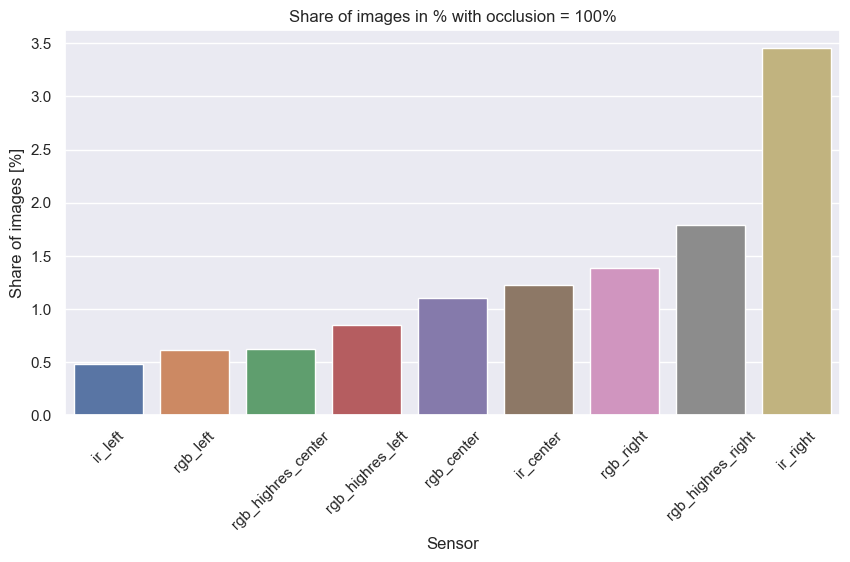

In [119]:
_ = sns.barplot(x=df_temp_2.index, y=df_temp_2).set(
    title="Share of images in % with occlusion = 100%",
    xlabel="Sensor",
    ylabel="Share of images [%]",
)
_ = plt.xticks(rotation=45)
df_temp_2

#### Examples of images/labels with occlusion = 100%

5_station_bergedorf_5.1/ir_center/071_1631529900.200464440.png


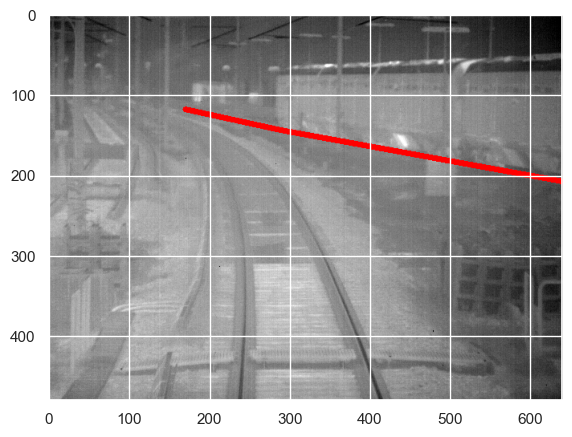

In [95]:
path = df_temp.iloc[54]["path"]
uid = df_temp.iloc[54]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

5_station_bergedorf_5.1/rgb_highres_center/099_1631529903.000000025.png


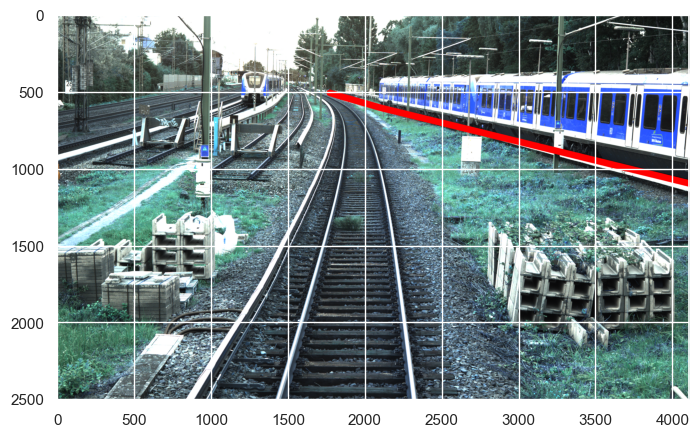

In [112]:
path = df_temp.iloc[-10]["path"]
uid = df_temp.iloc[-10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

18_vegetation_switch_18.1/rgb_center/079_1631625169.000000040.png


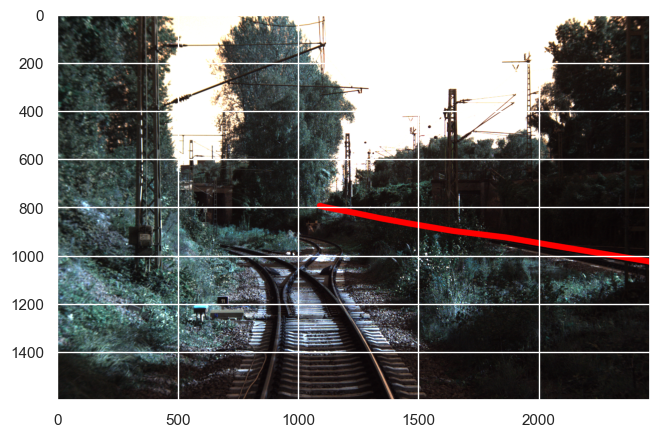

In [96]:
path = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["path"]
uid = df_temp[df_temp["sensor"] == "rgb_center"].iloc[10]["label_uid"]
print_image(df[df["label_uid"] == uid], path, True)

We decide to keep all images in the dataset as many of the covered labels might have a chance of being detected and because most images with covered labels have visible labels as well.

### Images as part of videos

Images are frames from videos. As such the variation between the images is low - especially when the train is not moving.
This is important to keep in mind when generating train, validation, and test sets (e.g. the accuracy of the model might be distorted with model is trained, validated, and tested on images with minimal differences)

In [32]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.3/rgb_highres_center/")
li.html(size=200, sample=7)

In [34]:
li = EasyImageList.from_folder("./orig_data/DB/3_fire_site_3.4/rgb_highres_center/")
li.html(size=200, sample=7)

In [120]:
li = EasyImageList.from_folder(
    "./orig_data/DB/4_station_pedestrian_bridge_4.1/rgb_highres_center/"
)
li.html(size=200, sample=7)

In [80]:
df.to_json(
    f"./dataframe_dumps/df_eda_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.json"
)